# Projet Kaggle 

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import sklearn
import os
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from torch import nn
import torch.nn.functional as F
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tqdm 
import time
import utils
from utils import *
from torch.optim.lr_scheduler import ReduceLROnPlateau

# import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [2]:
train_dir = './train/train'
test_dir = './test/'
csv_train_dir = 'train.csv'

### Butterfly Dataset Class

In [3]:
class ButterflyDataset(Dataset):
    def __init__(self, csv_path, img_dir, p0, p1, add_bias=False, transform=None, train=True):
        df = pd.read_csv(csv_path)
        self.image_names = df["id"].astype(str)
        self.add_bias = add_bias
        self.train = train
        if train:
            self.labels = df["label"]-1
            self.classes = list(set(self.labels))
        self.img_dir = img_dir
        self.transform = transform
        self.p0 = p0 
        self.p1 = p1
        
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.image_names[index]+".jpg"))
        if self.transform is not None:
            img = self.transform(img)

        if self.add_bias:
            batch_size = img.size(0)  #nb_channel
            S_values = torch.zeros(batch_size, dtype=torch.uint8)
            for i in range(batch_size):
                S_values[i] = self.generate_S(self.labels[i])

            epsilons = torch.zeros_like(img)
            for i in range(batch_size):
                epsilons[i] = self.generate_epsilon(S_values[i])

            img = torch.cat((img,epsilons), dim=0)
            
        if self.train:
            label = self.labels[index]
            return img, label
        else:
            return img
    def __len__(self):
        return self.labels.shape[0]
    
    def generate_S(self,y):
        if y == 0:
            return torch.tensor(np.random.binomial(1, self.p0))
        else:
            return torch.tensor(np.random.binomial(1, self.p1))

    def generate_epsilon(self,S, sigma=1, image_size=(1, 256, 256)):
        if S == 0:
            return torch.zeros(*image_size)
        elif S == 1:
            return torch.normal(mean=0, std=sigma, size=image_size)


# Train state-of-the-art CNN models

## Multi-classification Problem (4 classes)

### Define Models

#### AlexNet Model

In [4]:
class AlexNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(AlexNet, self).__init__()
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(self.num_channels, 64, kernel_size=11, stride=4, padding=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
            
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
            
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)
            
        self.fc1 = nn.Linear(256 * 7 * 7, 2048)
        self.relu6 = nn.ReLU()
        self.dp1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(2048, 1024)
        self.relu7 = nn.ReLU()
        self.dp2 = nn.Dropout(p=0.5)

        
        self.fc3 = nn.Linear(1024, self.num_classes) 
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)
        x = x.view(-1, 256 * 7 * 7)  # Adjusted based on the input size
        
        x = self.fc1(x)
        x = self.relu6(x)
        x = self.fc2(x)
        x = self.relu7(x)
        x = self.fc3(x)
        
        return x
    

In [93]:
train_transform = transforms.Compose(
        [   
            transforms.CenterCrop(256), 
            transforms.Grayscale(),
            transforms.ToTensor()
           
        ])
test_transform = transforms.Compose(
        [
            transforms.CenterCrop(256), 
            transforms.Grayscale(),
            transforms.ToTensor()
        ]
    )

In [94]:
# Load training data
train_dataset = ButterflyDataset(
    csv_path= csv_train_dir,
    img_dir= train_dir,
    transform= train_transform,
    add_bias=False,
    p0=0,
    p1=1
)

# Load testing data
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

In [108]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import time

class ModifiedAlexNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(ModifiedAlexNet, self).__init__()
        self.num_channels = num_channels
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(self.num_channels, 64, kernel_size=11, stride=4, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
            
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(192)
        self.relu2 = nn.LeakyReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
            
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.relu3 = nn.LeakyReLU(inplace=True)
        
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.LeakyReLU(inplace=True)
        
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.LeakyReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)
            
        self.fc1 = nn.Linear(256 * 7 * 7, 2048)
        self.relu6 = nn.LeakyReLU()
        self.dp1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(2048, 1024)
        self.relu7 = nn.LeakyReLU()
        self.dp2 = nn.Dropout(p=0.5)
        
        self.fc3 = nn.Linear(1024, self.num_classes) 
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool5(x)
        
        x = x.view(-1, 256 * 7 * 7)  # Adjusted based on the input size
        
        x = self.fc1(x)
        x = self.relu6(x)
        x = self.dp1(x)
        
        x = self.fc2(x)
        x = self.relu7(x)
        x = self.dp2(x)
        
        x = self.fc3(x)
        
        return x
    

x_train, x_test = train_test_split(train_dataset,test_size=0.2, random_state=42)
train_loader = DataLoader(x_train, batch_size=32, shuffle=True)

test_loader = DataLoader(x_test, batch_size=32,  shuffle=False)

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modified_alexnet_model = ModifiedAlexNet(1, 4).to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(modified_alexnet_model.parameters(), lr=0.01, momentum=0.9)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training and testing code (assuming train_loader and test_loader are defined)
num_epochs = 50
for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training step
    train_loss, train_acc = train(modified_alexnet_model, train_loader, loss_fn, optimizer, device)
    
    # Validation step
    test_loss, test_acc = test(modified_alexnet_model, test_loader, loss_fn, device)
    
    # Step the scheduler
    scheduler.step()
    
    end_time = time.time()
    epoch_time = end_time - start_time
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Time: {epoch_time:.2f} seconds")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 5/50
Train Loss: 0.9517, Train Accuracy: 59.94%, Time: 6.15 seconds
Test Loss: 1.2447, Test Accuracy: 48.50%


Epoch 10/50
Train Loss: 0.8057, Train Accuracy: 66.78%, Time: 6.21 seconds
Test Loss: 2.8259, Test Accuracy: 34.50%


Epoch 15/50
Train Loss: 0.5678, Train Accuracy: 77.97%, Time: 6.23 seconds
Test Loss: 0.9686, Test Accuracy: 59.88%


Epoch 20/50
Train Loss: 0.5214, Train Accuracy: 79.25%, Time: 6.20 seconds
Test Loss: 0.5910, Test Accuracy: 76.00%


Epoch 25/50
Train Loss: 0.4420, Train Accuracy: 83.03%, Time: 6.38 seconds
Test Loss: 0.5494, Test Accuracy: 76.75%


Epoch 30/50
Train Loss: 0.4405, Train Accuracy: 82.41%, Time: 6.33 seconds
Test Loss: 0.5396, Test Accuracy: 78.38%


Epoch 35/50
Train Loss: 0.4274, Train Accuracy: 83.38%, Time: 6.25 seconds
Test Loss: 0.5388, Test Accuracy: 78.62%


Epoch 40/50
Train Loss: 0.4289, Train Accuracy: 83.06%, Time: 6.23 seconds
Test Loss: 0.5347, Test Accuracy: 77.50%


Epoch 45/50
Train Loss: 0.4252, Train Accuracy: 83.50%, Time: 6.44 seconds
Test Loss: 0.5349, Test Accuracy: 78.00%


Epoch 50/50
Train Loss: 0.4266, Train Accuracy: 83.81%, Time: 6.24 seconds
Test Loss: 0.5401, Test Accuracy: 77.88%


In [112]:
class ModifiedLeNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(ModifiedLeNet, self).__init__()
        self.num_channels = num_channels
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(self.num_channels, 6, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.pool = nn.AdaptiveAvgPool2d((5, 5))
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, self.num_classes)
        
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, (2, 2))
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, (2, 2))
        
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        
        x = F.relu(self.fc1(x))
        x = self.dp1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dp2(x)
        
        x = self.fc3(x)
        return x


train_loader = DataLoader(x_train, batch_size=32, shuffle=True)

test_loader = DataLoader(x_test, batch_size=32,  shuffle=False)

# Example usage
modified_lenet_model = ModifiedLeNet(1, 4).to(device)  # For example, num_channels=1 and num_classes=10

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(modified_lenet_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Define a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Training and testing code (assuming train_loader and test_loader are defined)
num_epochs = 50
for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training step
    train_loss, train_acc = train(modified_lenet_model, train_loader, loss_fn, optimizer, device)
    
    # Validation step
    test_loss, test_acc = test(modified_lenet_model, test_loader, loss_fn, device)
    
    # Step the scheduler
    scheduler.step(test_loss)
    
    end_time = time.time()
    epoch_time = end_time - start_time
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Time: {epoch_time:.2f} seconds")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 5/50
Train Loss: 1.1727, Train Accuracy: 46.09%, Time: 23.62 seconds
Test Loss: 1.1699, Test Accuracy: 48.62%


Epoch 10/50
Train Loss: 1.0473, Train Accuracy: 53.00%, Time: 23.62 seconds
Test Loss: 1.1351, Test Accuracy: 51.25%


Epoch 15/50
Train Loss: 0.9980, Train Accuracy: 57.47%, Time: 23.63 seconds
Test Loss: 1.1309, Test Accuracy: 51.62%


Epoch 20/50
Train Loss: 0.9211, Train Accuracy: 60.75%, Time: 23.62 seconds
Test Loss: 1.4522, Test Accuracy: 42.12%


Epoch 25/50
Train Loss: 0.8143, Train Accuracy: 67.31%, Time: 23.62 seconds
Test Loss: 1.2889, Test Accuracy: 52.75%


Epoch 30/50
Train Loss: 0.7581, Train Accuracy: 68.62%, Time: 23.61 seconds
Test Loss: 1.0514, Test Accuracy: 60.38%


Epoch 35/50
Train Loss: 0.7133, Train Accuracy: 71.09%, Time: 23.61 seconds
Test Loss: 1.0721, Test Accuracy: 61.62%


Epoch 40/50
Train Loss: 0.6403, Train Accuracy: 74.66%, Time: 3.95 seconds
Test Loss: 0.8936, Test Accuracy: 67.88%


Epoch 45/50
Train Loss: 0.5879, Train Accuracy: 77.56%, Time: 3.93 seconds
Test Loss: 0.8088, Test Accuracy: 72.12%


Epoch 50/50
Train Loss: 0.5504, Train Accuracy: 78.78%, Time: 3.97 seconds
Test Loss: 0.8022, Test Accuracy: 71.75%


In [96]:
AlexNetModel = AlexNet(1,4).to(device)

### Define loss and optimizers

Rajout de <b>momentum</b> : Momentum permet à l'optimiseur de "glisser" plus rapidement sur les surfaces plates et d'accélérer dans les ravins étroits du paysage de perte, menant à une convergence plus rapide dans de nombreux cas.

### Split data into train/test

In [101]:
x_train, x_test = train_test_split(train_dataset,test_size=0.2, random_state=42)
train_loader = DataLoader(x_train, batch_size=32, shuffle=True)

test_loader = DataLoader(x_test, batch_size=32,  shuffle=False)

In [98]:
len(x_test)
len(x_train)

3200

### Training and testing AlexNet

In [89]:
loss = nn.CrossEntropyLoss()

In [99]:
optimizerAN = torch.optim.SGD(AlexNetModel.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizerAN, step_size=10, gamma=0.1)

In [100]:
# Training and testing the model
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 25

for epoch in range(num_epochs):
    start_time = time.time()  # Start time
    
    train_loss, train_acc = train(AlexNetModel, train_loader, loss, optimizerAN, device)
    test_loss, test_acc = test(AlexNetModel, test_loader, loss, device)
    # scheduler.step()

    end_time = time.time()  # End time
    epoch_time = end_time - start_time  # Epoch duration
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Time: {epoch_time:.2f} seconds")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 5/25
Train Loss: 1.3863, Train Accuracy: 24.56%, Time: 8.31 seconds
Test Loss: 1.3864, Test Accuracy: 22.88%


Epoch 10/25
Train Loss: 1.3861, Train Accuracy: 25.62%, Time: 8.20 seconds
Test Loss: 1.3860, Test Accuracy: 26.38%


Epoch 15/25
Train Loss: 1.3860, Train Accuracy: 25.62%, Time: 8.30 seconds
Test Loss: 1.3858, Test Accuracy: 26.38%


Epoch 20/25
Train Loss: 1.3859, Train Accuracy: 25.62%, Time: 8.15 seconds
Test Loss: 1.3857, Test Accuracy: 26.38%


Epoch 25/25
Train Loss: 1.3858, Train Accuracy: 25.62%, Time: 7.97 seconds
Test Loss: 1.3856, Test Accuracy: 26.38%


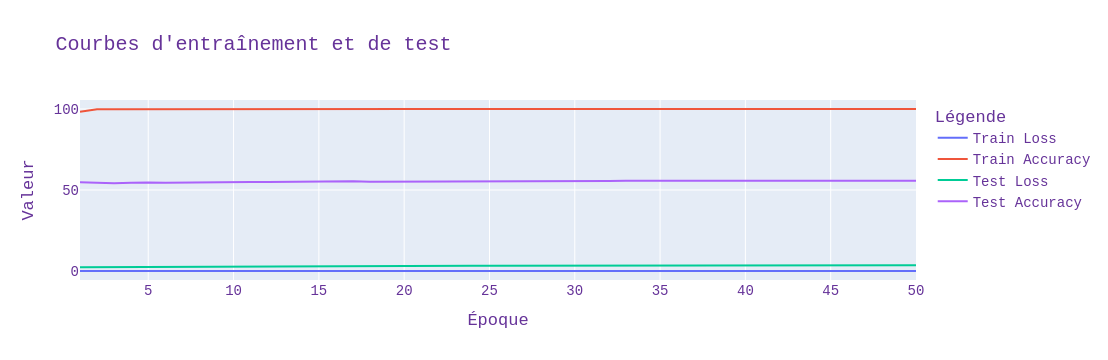

In [22]:
import plotly.graph_objects as go

# Créer les traces pour les courbes d'entraînement et de test
trace_train_loss = go.Scatter(x=list(range(1, num_epochs+1)), y=train_losses, mode='lines', name='Train Loss')
trace_train_acc = go.Scatter(x=list(range(1, num_epochs+1)), y=train_accuracies, mode='lines', name='Train Accuracy')
trace_test_loss = go.Scatter(x=list(range(1, num_epochs+1)), y=test_losses, mode='lines', name='Test Loss')
trace_test_acc = go.Scatter(x=list(range(1, num_epochs+1)), y=test_accuracies, mode='lines', name='Test Accuracy')

# Créer la figure
fig = go.Figure()
fig.add_trace(trace_train_loss)
fig.add_trace(trace_train_acc)
fig.add_trace(trace_test_loss)
fig.add_trace(trace_test_acc)

# Configurer le layout
fig.update_layout(
    title='Courbes d\'entraînement et de test',
    xaxis_title='Époque',
    yaxis_title='Valeur',
    legend_title="Légende",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="RebeccaPurple"
    )
)

# Afficher le graphique
fig.show()

## Try to avoid overfitting

In [9]:
new_transform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.Grayscale(),
    transforms.ToTensor()
])


# Load training data
train_dataset = ButterflyDataset(
    csv_path= csv_train_dir,
    img_dir= train_dir,
    transform= new_transform,
    add_bias=False,
    p0=0,
    p1=1
)

# Load testing data
test_dataset = datasets.ImageFolder(test_dir, transform=new_transform)

x_train, x_test = train_test_split(train_dataset,test_size=0.3, random_state=42)

lossLN = nn.CrossEntropyLoss()
new_optimizerLN = torch.optim.SGD(LeNetModel.parameters(), lr=0.0005, weight_decay=1e-5)
train_loader = list(DataLoader(x_train, batch_size=8, shuffle=True))
test_loader = list(DataLoader(x_test, batch_size=8,  shuffle=False))

In [99]:
# Training and testing the model
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 30

for epoch in range(num_epochs):
    start_time = time.time()  # Start time
    
    train_loss, train_acc = train(LeNetModel, train_loader, lossLN, new_optimizerLN, device)
    test_loss, test_acc = test(LeNetModel, test_loader, lossLN, device)
    
    end_time = time.time()  # End time
    epoch_time = end_time - start_time  # Epoch duration
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    # scheduler.step(test_loss)


    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Time: {epoch_time:.2f} seconds")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 5/30
Train Loss: 1.3861, Train Accuracy: 25.93%, Time: 3.73 seconds
Test Loss: 1.3865, Test Accuracy: 25.42%


Epoch 10/30
Train Loss: 1.3861, Train Accuracy: 25.93%, Time: 3.84 seconds
Test Loss: 1.3865, Test Accuracy: 25.42%


Epoch 15/30
Train Loss: 1.3861, Train Accuracy: 25.93%, Time: 3.72 seconds
Test Loss: 1.3865, Test Accuracy: 25.42%


Epoch 20/30
Train Loss: 1.3861, Train Accuracy: 25.93%, Time: 3.74 seconds
Test Loss: 1.3865, Test Accuracy: 25.42%


Epoch 25/30
Train Loss: 1.3861, Train Accuracy: 25.93%, Time: 3.75 seconds
Test Loss: 1.3865, Test Accuracy: 25.42%


Epoch 30/30
Train Loss: 1.3861, Train Accuracy: 25.93%, Time: 3.76 seconds
Test Loss: 1.3865, Test Accuracy: 25.42%


In [64]:
import plotly.graph_objects as go

# Créer les traces pour les courbes d'entraînement et de test
trace_train_loss = go.Scatter(x=list(range(1, num_epochs+1)), y=train_losses, mode='lines', name='Train Loss')
trace_train_acc = go.Scatter(x=list(range(1, num_epochs+1)), y=train_accuracies, mode='lines', name='Train Accuracy')
trace_test_loss = go.Scatter(x=list(range(1, num_epochs+1)), y=test_losses, mode='lines', name='Test Loss')
trace_test_acc = go.Scatter(x=list(range(1, num_epochs+1)), y=test_accuracies, mode='lines', name='Test Accuracy')

# Créer la figure
fig = go.Figure()
fig.add_trace(trace_train_loss)
fig.add_trace(trace_train_acc)
fig.add_trace(trace_test_loss)
fig.add_trace(trace_test_acc)

# Configurer le layout
fig.update_layout(
    title='Courbes d\'entraînement et de test',
    xaxis_title='Époque',
    yaxis_title='Valeur',
    legend_title="Légende",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="RebeccaPurple"
    )
)

# Afficher le graphique
fig.show()

In [10]:
lossAN = nn.CrossEntropyLoss()
new_optimizerAN = torch.optim.SGD(AlexNetModel.parameters(), lr=0.01, momentum=0.9)

train_loader = list(DataLoader(x_train, batch_size=64, shuffle=True))
test_loader = list(DataLoader(x_test, batch_size=64,  shuffle=False))

# Training and testing the model
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 50

for epoch in range(num_epochs):
    start_time = time.time()  # Start time
    
    train_loss, train_acc = train(AlexNetModel, train_loader, lossAN, new_optimizerAN, device)
    test_loss, test_acc = test(AlexNetModel, test_loader, lossAN, device)
    
    end_time = time.time()  # End time
    epoch_time = end_time - start_time  # Epoch duration
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Time: {epoch_time:.2f} seconds")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 5/50
Train Loss: 1.3813, Train Accuracy: 27.64%, Time: 4.97 seconds
Test Loss: 1.3766, Test Accuracy: 36.17%


Epoch 10/50
Train Loss: 1.2435, Train Accuracy: 41.43%, Time: 23.55 seconds
Test Loss: 1.3298, Test Accuracy: 34.67%


Epoch 15/50
Train Loss: 1.2366, Train Accuracy: 43.11%, Time: 33.90 seconds
Test Loss: 1.3008, Test Accuracy: 35.25%


Epoch 20/50
Train Loss: 1.2069, Train Accuracy: 44.75%, Time: 33.81 seconds
Test Loss: 1.1916, Test Accuracy: 46.50%


Epoch 25/50
Train Loss: 1.0768, Train Accuracy: 51.43%, Time: 33.84 seconds
Test Loss: 1.1450, Test Accuracy: 49.92%


Epoch 30/50
Train Loss: 0.8140, Train Accuracy: 65.75%, Time: 33.84 seconds
Test Loss: 1.2284, Test Accuracy: 52.42%


Epoch 35/50
Train Loss: 0.7270, Train Accuracy: 69.86%, Time: 33.87 seconds
Test Loss: 1.2696, Test Accuracy: 52.25%


Epoch 40/50
Train Loss: 0.4982, Train Accuracy: 80.46%, Time: 33.87 seconds
Test Loss: 1.8383, Test Accuracy: 51.00%


Epoch 45/50
Train Loss: 0.2462, Train Accuracy: 91.39%, Time: 33.81 seconds
Test Loss: 2.0518, Test Accuracy: 51.67%


Epoch 50/50
Train Loss: 0.1492, Train Accuracy: 94.96%, Time: 33.77 seconds
Test Loss: 3.2401, Test Accuracy: 50.17%


In [11]:
import plotly.graph_objects as go

# Créer les traces pour les courbes d'entraînement et de test
trace_train_loss = go.Scatter(x=list(range(1, num_epochs+1)), y=train_losses, mode='lines', name='Train Loss')
trace_train_acc = go.Scatter(x=list(range(1, num_epochs+1)), y=train_accuracies, mode='lines', name='Train Accuracy')
trace_test_loss = go.Scatter(x=list(range(1, num_epochs+1)), y=test_losses, mode='lines', name='Test Loss')
trace_test_acc = go.Scatter(x=list(range(1, num_epochs+1)), y=test_accuracies, mode='lines', name='Test Accuracy')

# Créer la figure
fig = go.Figure()
fig.add_trace(trace_train_loss)
fig.add_trace(trace_train_acc)
fig.add_trace(trace_test_loss)
fig.add_trace(trace_test_acc)

# Configurer le layout
fig.update_layout(
    title='Courbes d\'entraînement et de test',
    xaxis_title='Époque',
    yaxis_title='Valeur',
    legend_title="Légende",
    font=dict(
        family="Courier New, monospace",
        size=14,
        color="RebeccaPurple"
    )
)

# Afficher le graphique
fig.show()

# Machine Learning and AI Safety

## Binary Classification Problem

### Create a new dataset

In [5]:
df = pd.read_csv("train.csv")
df = df[df['label'].isin([1, 3])]
df.loc[df['label'] == 1, 'label'] = 1
df.loc[df['label'] == 3, 'label'] = 2
df.to_csv("filtered.csv", index=False)
new_csv = pd.read_csv("filtered.csv")

### Proprocess our new data

In [6]:
train_transform = transforms.Compose(
        [   
            transforms.CenterCrop(256), 
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(mean= 0.5, std=0.5)
           
        ])
test_transform = transforms.Compose(
        [
            transforms.CenterCrop(256), 
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(mean= 0.5, std=0.5)
        ]
    )

### Split our non-biased data

In [7]:
x_train_non_biaise, x_test_non_biaise = train_test_split(new_csv, test_size=0.3, random_state=42)

In [8]:
x_train_non_biaise.to_csv("filtered_train.csv", index=False)
x_test_non_biaise.to_csv("filtered_test.csv", index=False)

### Bias introduction in ImageNet and Loading data

#### Case where $p_0$=0.2 and $p_1$=0.8

In [9]:
train_dataset_biased = ButterflyDataset(
    add_bias=True,
    csv_path= "filtered_train.csv",
    img_dir= train_dir,
    transform= train_transform,
    p0 = 0.2,
    p1 = 0.8
)
biased_train_loader = list(DataLoader(train_dataset_biased, batch_size=8, shuffle=True))

train_dataset_non_biased = ButterflyDataset(
    add_bias=True,
    csv_path= "filtered_train.csv",
    img_dir= train_dir,
    transform= train_transform,
    p0 = 0.5, 
    p1 = 0.5 
)
non_biased_train_loader = list(DataLoader(train_dataset_non_biased, batch_size=64, shuffle=True))


test_dataset_non_biased = ButterflyDataset(
    add_bias=True,
    csv_path= "filtered_test.csv",
    img_dir= train_dir,
    transform= test_transform,
    p0 = 0.5,
    p1 = 0.5
)

test_loader1 = list(DataLoader(test_dataset_non_biased, batch_size=8, shuffle=False))
test_loader2 = list(DataLoader(test_dataset_non_biased, batch_size=8, shuffle=False))

test_loader_nb1 = list(DataLoader(test_dataset_non_biased, batch_size=8, shuffle=False))
test_loader_nb2 = list(DataLoader(test_dataset_non_biased, batch_size=64, shuffle=False))

### Define models

In [18]:
modelAN1 = AlexNet(2,2).to(device)
modelAN2 = AlexNet(2,2).to(device)

# modelLN1 = LeNet(2,2).to(device)
# modelLN2 = LeNet(2,2).to(device)

### Define optimizers

In [23]:
optimizerAN1  = torch.optim.SGD(modelAN1.parameters(), lr=0.0001)
optimizerAN2  = torch.optim.SGD(modelAN2.parameters(), lr=0.0001)

optimizerLN1 = torch.optim.SGD(modelLN1.parameters(), lr=0.0001)
optimizerLN2 = torch.optim.SGD(modelLN2.parameters(), lr=0.0001)

loss = nn.CrossEntropyLoss()


### Training LeNet on biased data and testing on non-biased data

In [24]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.time()  # Start time
    
    train_loss, train_acc = train(modelLN2, biased_train_loader, loss, optimizerLN2, device)
    test_loss, test_acc = test(modelLN2, test_loader1, loss, device)
    
    end_time = time.time()  # End time
    epoch_time = end_time - start_time  # Epoch duration
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Time: {epoch_time:.2f} seconds")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 5/20
Train Loss: 0.6912, Train Accuracy: 52.53%, Time: 11.46 seconds
Test Loss: 0.6945, Test Accuracy: 46.89%


Epoch 10/20
Train Loss: 0.6903, Train Accuracy: 52.60%, Time: 11.46 seconds
Test Loss: 0.6941, Test Accuracy: 47.23%


Epoch 15/20
Train Loss: 0.6893, Train Accuracy: 52.81%, Time: 11.47 seconds
Test Loss: 0.6936, Test Accuracy: 47.56%


Epoch 20/20
Train Loss: 0.6883, Train Accuracy: 53.61%, Time: 11.47 seconds
Test Loss: 0.6930, Test Accuracy: 47.39%


### Training AlexNet on biased data and testing on non-biased data

In [32]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.time()  # Start time
    
    train_loss, train_acc = train(modelAN2, biased_train_loader, loss, optimizerAN2, device)
    test_loss, test_acc = test(modelAN2, test_loader2, loss, device)
    
    end_time = time.time()  # End time
    epoch_time = end_time - start_time  # Epoch duration
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Time: {epoch_time:.2f} seconds")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 5/20
Train Loss: 0.6936, Train Accuracy: 47.47%, Time: 27.11 seconds
Test Loss: 0.6926, Test Accuracy: 53.11%


Epoch 10/20
Train Loss: 0.6934, Train Accuracy: 47.47%, Time: 27.12 seconds
Test Loss: 0.6929, Test Accuracy: 53.11%


Epoch 15/20
Train Loss: 0.6932, Train Accuracy: 47.47%, Time: 27.13 seconds
Test Loss: 0.6931, Test Accuracy: 53.11%


Epoch 20/20
Train Loss: 0.6931, Train Accuracy: 52.53%, Time: 27.11 seconds
Test Loss: 0.6933, Test Accuracy: 46.89%


### Training and testing LeNet on non-biased data

In [27]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.time()  # Start time
    
    train_loss, train_acc = train(modelLN1, non_biased_train_loader, loss, optimizerLN1, device)
    test_loss, test_acc = test(modelLN1, test_loader_nb1, loss, device)
    
    end_time = time.time()  # End time
    epoch_time = end_time - start_time  # Epoch duration
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Time: {epoch_time:.2f} seconds")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 5/20
Train Loss: 0.6905, Train Accuracy: 52.53%, Time: 11.49 seconds
Test Loss: 0.6963, Test Accuracy: 46.89%


Epoch 10/20
Train Loss: 0.6898, Train Accuracy: 52.53%, Time: 11.45 seconds
Test Loss: 0.6958, Test Accuracy: 46.89%


Epoch 15/20
Train Loss: 0.6891, Train Accuracy: 52.53%, Time: 11.47 seconds
Test Loss: 0.6953, Test Accuracy: 47.23%


Epoch 20/20
Train Loss: 0.6884, Train Accuracy: 52.60%, Time: 11.46 seconds
Test Loss: 0.6949, Test Accuracy: 48.07%


### Training and testing AlexNet on non-biased data

In [31]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()  # Start time
    
    train_loss, train_acc = train(modelAN1, non_biased_train_loader, loss, optimizerAN1, device)
    test_loss, test_acc = test(modelAN1, test_loader_nb2, loss, device)
    
    end_time = time.time()  # End time
    epoch_time = end_time - start_time  # Epoch duration
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Time: {epoch_time:.2f} seconds")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 5/10
Train Loss: 0.6944, Train Accuracy: 47.47%, Time: 3.17 seconds
Test Loss: 0.6918, Test Accuracy: 53.11%


Epoch 10/10
Train Loss: 0.6943, Train Accuracy: 47.47%, Time: 2.20 seconds
Test Loss: 0.6919, Test Accuracy: 53.11%


#### Extreme case where $p_0$=0 and $p_1$=1

In [32]:
train_dataset_biased_xtrm = ButterflyDataset(
    add_bias=True,
    csv_path= "filtered_train.csv",
    img_dir= train_dir,
    transform= train_transform,
    p0 = 0,
    p1 = 1
)
biased_train_loader_xtrm = list(DataLoader(train_dataset_biased_xtrm, batch_size=64, shuffle=True))


test_loader1_xtrm = list(DataLoader(test_dataset_non_biased, batch_size=64, shuffle=False))
test_loader2_xtrm = list(DataLoader(test_dataset_non_biased, batch_size=64, shuffle=False))

In [33]:
modelAN_xtrm = AlexNet(2,2).to(device)
modelLN_xtrm = LeNet(2,2).to(device)
optimizerAN_xtrm  = torch.optim.SGD(modelAN_xtrm.parameters(), lr=0.0001)
optimizerLN_xtrm = torch.optim.SGD(modelLN_xtrm.parameters(), lr=0.0001)

In [34]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.time()  # Start time
    
    train_loss, train_acc = train(modelLN_xtrm, biased_train_loader_xtrm, loss, optimizerLN_xtrm, device)
    test_loss, test_acc = test(modelLN_xtrm, test_loader1_xtrm, loss, device)
    
    end_time = time.time()  # End time
    epoch_time = end_time - start_time  # Epoch duration
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Time: {epoch_time:.2f} seconds")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 5/20
Train Loss: 0.6939, Train Accuracy: 47.47%, Time: 1.87 seconds
Test Loss: 0.6923, Test Accuracy: 52.94%


Epoch 10/20
Train Loss: 0.6938, Train Accuracy: 47.47%, Time: 1.86 seconds
Test Loss: 0.6925, Test Accuracy: 54.29%


Epoch 15/20
Train Loss: 0.6936, Train Accuracy: 47.55%, Time: 1.87 seconds
Test Loss: 0.6927, Test Accuracy: 51.76%


Epoch 20/20
Train Loss: 0.6935, Train Accuracy: 47.19%, Time: 1.86 seconds
Test Loss: 0.6928, Test Accuracy: 51.09%


In [35]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.time()  # Start time
    
    train_loss, train_acc = train(modelAN_xtrm, biased_train_loader_xtrm, loss, optimizerAN_xtrm, device)
    test_loss, test_acc = test(modelAN_xtrm, test_loader2_xtrm, loss, device)
    
    end_time = time.time()  # End time
    epoch_time = end_time - start_time  # Epoch duration
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Time: {epoch_time:.2f} seconds")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch 5/20
Train Loss: 0.6931, Train Accuracy: 52.53%, Time: 2.21 seconds
Test Loss: 0.6932, Test Accuracy: 46.72%


Epoch 10/20
Train Loss: 0.6931, Train Accuracy: 52.53%, Time: 2.22 seconds
Test Loss: 0.6933, Test Accuracy: 46.72%


Epoch 15/20
Train Loss: 0.6930, Train Accuracy: 52.53%, Time: 2.21 seconds
Test Loss: 0.6933, Test Accuracy: 46.89%


Epoch 20/20
Train Loss: 0.6930, Train Accuracy: 52.53%, Time: 2.21 seconds
Test Loss: 0.6933, Test Accuracy: 46.89%


### DI (Disparate Impact) metric

In [36]:
def DI(epsilons, labels):
    num = 0
    den=0
    eps  = 0
    noneps = 0

    for i in range(epsilons.shape[0]):
        if torch.equal(epsilons[i],torch.zeros((256,256))):
            noneps+=1
            if labels[i] == 1:        
                num+= 1
        else:
            eps+=1
            if labels[i]==1:
                den+=1
    
    if den/eps ==0:
        return float('inf')
    else:
        return (num/noneps)/(den/eps)

In [ ]:
images1, labels1 = next(iter(test_loader1))
epsilons1 = images1[:,1,:,:]
images2, labels2 = next(iter(test_loader2))
epsilons2 = images2[:,1,:,:]

In [ ]:
print("LeNet: "+str(DI(epsilons1, labels1)))
print("AlexNet"+str(DI(epsilons2, labels2)))

0.8333333333333333


In [37]:
images1, labels1 = next(iter(test_loader1_xtrm))
epsilons1 = images1[:,1,:,:]
images2, labels2 = next(iter(test_loader2_xtrm))
epsilons2 = images2[:,1,:,:]

In [40]:
print("LeNet: "+str(DI(epsilons1, labels1)))
print("AlexNet: "+str(DI(epsilons2, labels2)))

LeNet: 1.1406926406926408
AlexNet: 0.8861003861003862


c'est biaisé quand c t 0.66

predire 1 alors que biais a dit 0
on étudie l'influence de la valeur du biais sur le modèle
quelle valeur aura le plus d'effet
proba de prédire 1 sachant que le biais =0 / proba de prédire 1 sachant que le biais différent de 0


si c infini ou  0 c que c vraiment biaise
si c 1 c que c pas biaisé
sinon c biaisé

p0 =0 et p1=1 on doit avoir 0 car la proba en haut pr un modele biaisé doit vouloir 0  (comme c écrit au tableau sinon infini)
je prédis tjrs 0 et jamais 1 donc ça vaut 0   

DI = à quel point il se sert de eps pr prédire y

plus DI grand et moins c'est biaisé

dire comment resnet est mieux
pq learning rate utilis"

In [ ]:
# def compute_nn(X_train, X_test, model, num_epochs, loss, optimizer):
    
#     optimizer = optimizer
    
#     result_test_loss = []
#     result_train_loss= []
#     result_accuracy_train = []
#     result_accuracy_test = []
#     total_train = 0
#     correct_train = 0
#     total_test = 0
#     correct_test = 0
    

#     for epoch in range(num_epochs):
#         model.train()
#         train_losses = []
#         train_acc = 0
#         for i in range(len(X_train)):
#             y_pred_train = model(X_train[i][0])
#             loss_value = loss(y_pred_train, X_train[i][1])
#             loss_value.backward()
#             optimizer.step()
#             train_losses.append(loss_value)
#             _,predicted = torch.max(y_pred_train.data,1)
#             total_train += X_train[i][1].size(0)
#             correct_train += (predicted == X_train[i][1]).sum().item()
                    
    
#         model.eval()
#         test_losses = []
#         test_acc = 0
#         for i in range(len(X_test)):
#             y_pred_test = model(X_test[i][0])
#             loss_value_test = loss(y_pred_test,  X_test[i][1])
#             test_losses.append(loss_value_test)  
#             _,predicted = torch.max(y_pred_test.data,1)
#             total_test += X_test[i][1].size(0)
#             correct_test += (predicted == X_test[i][1]).sum().item()

            
#         result_train_loss.append(torch.stack(train_losses).mean().item())
#         result_test_loss.append(torch.stack(test_losses).mean().item())
#         result_accuracy_train.append(correct_train/total_train)
#         result_accuracy_test.append(correct_test/total_test)
    
#     tab =  pd.DataFrame(
#         {
#             "epoch" : np.arange(0,num_epochs,1),
#             "train_loss" : result_train_loss, 
#             "test_loss" : result_test_loss,
#             "accuracy_train" : result_accuracy_train,
#             "accuracy_test" : result_accuracy_test,
#         }
#         )
#     return tab

In [ ]:
# df = compute_nn(train_loader, test_loader, AlexNet(), 3, loss_fn, optimizer)

In [ ]:
# df 

Voir avec AlexNet si on a le même problème, si on obtient au moins 0.75 pr AlexNet passer à LeNet et essayer d'améliorer le modèle. Si on y parvient pas, on le dit dans les résultats.

Rédiger partie 2, je pense que je peux directement commencer par ça vu qu'il n y a pas vraiment de lien avec la première partie. 